In [18]:
# You can set your own compiled m2aia libraries by adding M2AIA_PATH
# import os
# os.environ["M2AIA_PATH"] = "/home/jtfc/HS/M2aia/m2aia-dev/m2aia-release/MITK-build/lib/"

import m2aia as m2
import numpy as np

In [19]:
# download the example files if required
# for all examples continuos profile data are used
from download_helper import DownloadMTBLS2639
# if wanted, you can replace the file_names list with data on your disk
# e.g. filenames = ["my/files/location/data.imzML", "..."]
file_names = DownloadMTBLS2639(selection=[1,2,3,4]) # only slice 3 is selected, you choose fom [0,1,2,3]

In [20]:
import torch
import pathlib
import matplotlib.pyplot as plt 

from torchvision import transforms
from torch.utils.data import  DataLoader, SubsetRandomSampler
from torch.optim import Adam
import matplotlib.pyplot as plt

In [21]:
#===================================
# 1.1 Load image handles
#===================================
image_handles = []
for f in file_names:
    I = m2.ImzMLReader(f)
    xs = I.GetXAxis()
    image_handles.append(I)

[2859.618] [imzML]: data/150429_ew_section1_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 206x107x1
	[num spectra]: 16418
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
[2884.354] [imzML]: data/150429_ew_section2_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 220x171x1
	[num spectra]: 26744
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
[2910.228] [imzML]: data/150505_ew_section3_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 224x169x1
	[num spectra]: 28278
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
[2935.695] [imzML]: data/150417_ew_section4_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 197x192x1
	[num spectra]: 28156
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measureme

In [22]:
#========================================
# 1.2 Batch generator (with neighborhood)
#========================================

# to query samples from the dataset with output tensor shape [B,C,W,H]
# with B as batch size
# C as number of channels (m/z values)
# and W,H as width and height of the queried patch

transform = transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32))
dataset = m2.SpectrumDataset(image_handles, shape=(3,3), buffer_type="memory", transform_data=transform)
print("3x3 => [B,C=1,D,H=3,W=3]",dataset[0][0].shape)

3x3 => [B,C=1,D,H=3,W=3] torch.Size([1, 29693, 3, 3])


In [23]:
from Example_VI_Helpers import VAE, VAE_Loss
epochs = 5
batch_size = 128
latent_size = 5

m = VAE(xs.shape[-1],interim_dim=512, latent_size=latent_size)
m = m.cuda()

In [27]:
models_root = pathlib.Path('models')
models_root.mkdir(exist_ok=True)
models_path = models_root.joinpath("Example_VI.model")

if models_path.exists():
    #===================================
    # 3A Load trained model parameters
    #===================================
    state_dict = torch.load(str(models_path))
    m.load_state_dict(state_dict)
else:
    #===================================
    # 3B Model training
    #===================================
    loss = VAE_Loss(batch_size)
    loss = loss.cuda()

    optim = Adam(m.parameters())

    dataloader = DataLoader(dataset,
                            batch_size = batch_size, 
                            sampler = SubsetRandomSampler(list(range(len(dataset)))),
                            pin_memory = True,
                            drop_last = True)

    m.train()
    ## main fit steps
    total_losses = []
    for epoch in range(epochs):
        # 1. train
        epoch_losses = []
        for i, (X,Y) in enumerate(dataloader):
            
            X = X.cuda(non_blocking=True)
            R, z, z_mean, z_log_var = m(X)
            
            loss_value = loss(X, R, z_mean, z_log_var)

            # record
            epoch_losses.append(loss_value)
            
            # backward
            optim.zero_grad()
            loss_value.backward()
            optim.step()

        # update lr
        # scheduler.step()
        losses_np = torch.tensor(epoch_losses).cpu().numpy()
        print('epoch {} loss: {}'.format(epoch, np.mean(losses_np)))

    torch.save(m.state_dict(), str(models_path))

epoch 0 loss: 29.942960739135742
epoch 1 loss: 15.355179786682129
epoch 2 loss: 14.343624114990234
epoch 3 loss: 13.834189414978027
epoch 4 loss: 13.480172157287598


In [28]:
m.eval()

N = 0
ims = []
x_dims = []
y_dims = []
for j, I in enumerate(image_handles):
    x_dim, y_dim, z_dim = I.GetShape()
    im = np.zeros((latent_size, y_dim, x_dim))
    x_dims.append(x_dim)
    y_dims.append(y_dim)
      
    for id in range(I.GetNumberOfSpectra()):
        
        c, z_mean, z_log_var = m.encoder(dataset[id+N][0][None,...].cuda())
        c = c.cpu().detach().numpy()
        x,y,z = I.GetSpectrumPosition(id)
        im[:, y, x] = c[0,:]
    N = N + I.GetNumberOfSpectra()
    ims.append(im)

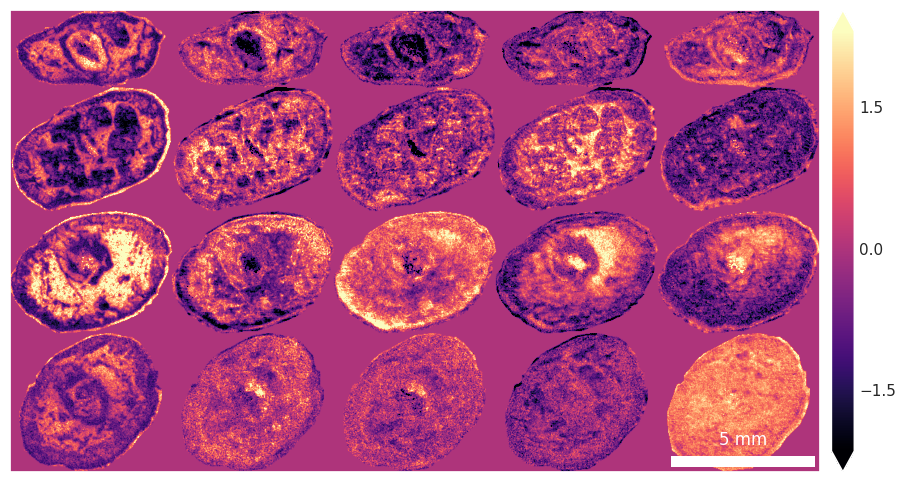

In [29]:
import seaborn_image as seaim
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(19,6)})

height = np.sum(y_dims)
max_im_width = np.max(x_dims)
width = max_im_width * latent_size

im_final = np.zeros((height, width))


y_pos = 0
for i, ims_temp in enumerate(ims):
    d,h,w = ims_temp.shape
    min = np.min(ims_temp)
    max = np.max(ims_temp)
    x_pos = 0
    for k in range(latent_size):
        rescaled = np.copy(ims_temp[k])
        w_delta_2 = (max_im_width-w)/2
        im_final[y_pos:y_pos + h , x_pos+int(w_delta_2):x_pos+int(w_delta_2)+w] = rescaled
        x_pos = x_pos + max_im_width
    y_pos = y_pos + h

# im_final[im_final!=0] = im_final[im_final!=0]+3.5
seaim.imshow(im_final, cmap="magma", dx=25, units="um", perc=(1,99), robust=True,interpolation='bilinear')
plt.savefig(dpi=350, fname="results/example_vi.png")